### 이항 분류, CPU
#### 표준화하지 않은 데이터 사용: country1.csv

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/country' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
# 데이터 준비
data = np.loadtxt('../../data/country/country1.csv', delimiter=',', dtype=np.float64
                  ,skiprows=1)
print(type(data))
print(data.shape)
print(data[:3])

<class 'numpy.ndarray'>
(100, 7)
[[ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  0.  1.]]


In [3]:
# 데이터 분할
X = data[:, :6]
print(X[:3])
Y = data[:, 6]
print(Y[:3])

[[ 0.  0.  0.  5.  1.  0.]
 [ 1.  0.  1.  6.  1.  0.]
 [ 1.  1.  1. 10.  1.  0.]]
[0. 1. 1.]


In [4]:
# 훈련용 + 검증용: 90 건, 테스트용: 10 건
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(x_train.shape) # 훈련+검증
print(y_train.shape) # 훈련+검증
print(x_test.shape)  # 테스트
print(y_test.shape)  # 테스트

(90, 6)
(90,)
(10, 6)
(10,)


In [5]:
# 네트워크 설계
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Dense(30, input_dim=6, activation='relu', name='layer1'))
model.add(Dense(20, activation='relu', name='layer2'))
model.add(Dense(1, activation='sigmoid', name='layer5')) # 이항분류: 0 ~ 1
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# patience=3: 손실이 3번 늘어날때까지 훈련을 계속, 3번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
    os.mkdir(MODEL_DIR) # 폴더 생성

# 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
# epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
# val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

# 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
# filepath=modelpath: 파일이 저장되는 경로와 파일명
# monitor='val_accuracy': 검증 정확도 기준으로 판단
# verbose=1: 기록되는 파일 정보 출력
# save_best_only=True: 검증 정확도가 개선되면 파일로 저장
mcp= ModelCheckpoint(filepath=modelpath,
                    monitor='val_accuracy',
                    verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
                 epochs=10, batch_size=1, callbacks=[es, mcp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 30)                210       
                                                                 
 layer2 (Dense)              (None, 20)                620       
                                                                 
 layer5 (Dense)              (None, 1)                 21        
                                                                 
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
55/72 [=====================>........] - ETA: 0s - loss: 8.7524 - accuracy: 0.6000 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./model\001-0.5000.h5
72/72 [==============================] - 1s 4ms/step - loss: 7.5297 - accuracy: 0.5417 - val_loss: 5.0350 - val_accuracy: 0.5000
Epoch 2

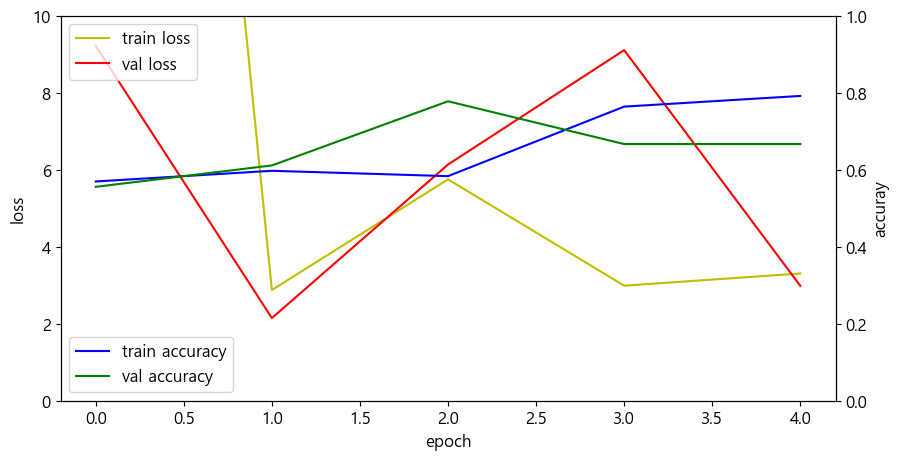

In [6]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련 손실
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증 손실, 학습의 우수성 평가 척도
loss_ax.set_ylim([0.0, 10]) # 왼쪽 y 축, 값을 반영하여 변경

acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')   # 훈련 정확도
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy') # 검증 정확도
acc_ax.set_ylim([0.0, 1.0])  # 오른쪽 y 축, 0 ~100 %를 의미

loss_ax.set_xlabel('epoch')  # x축 레이블
loss_ax.set_ylabel('loss')     # 왼쪽 y 레이블
acc_ax.set_ylabel('accuray') # 오른쪽 y 레이블

loss_ax.legend(loc='upper left')  # 좌측 y 축 기준 범례 위치 설정
acc_ax.legend(loc='lower left')   # 우측 y 축 기준 범례 위치 설정

plt.show()

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.6751086711883545 /정확도: 69.9999988079071 %
